## Perhitungan Nilai Seeing dengan Metode Trail

Oleh    : Irfan Imaduddin <br>
Tanggal : 22 Desember 2021 <br>
Ref     : Gochermann et al, 1999 <br>
Versi   : 2.0 <br>
Kontak  : irfanimaduddin@gmail.com <br>

---

Import modul yang digunakan

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as tr
from matplotlib import dates
import matplotlib.animation as animation
from IPython import display

from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename as file
from astropy.modeling import models, fitting
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy import units as u
from astropy.time import Time

from lmfit.models import ConstantModel, GaussianModel, PolynomialModel

from photutils.segmentation import SourceCatalog
from photutils import detect_sources, deblend_sources
from photutils import detect_threshold

Konfigurasi plot

In [2]:
plt.style.use(astropy_mpl_style)

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)            # legend fontsize

%matplotlib inline

Mencari base directory

In [3]:
BASE_DIR = os.getcwd()

Definisikan nama file

In [4]:
PLATENUM = '24039'
DPI      = 1200
FILENUM  = '001'

DIRECTORY = 'v{}'.format(PLATENUM)
FILENAME  = 'v{}-{}-{}.fit'.format(PLATENUM, DPI, FILENUM)
FILEPATH = os.path.join(BASE_DIR, DIRECTORY, FILENAME)

Membuka file

In [5]:
image = fits.open(FILEPATH)
img_hdr  = fits.getheader(FILEPATH, ext=0)
img_data = fits.getdata(FILEPATH, ext=0)

Transpose dan flip data pada sumbu x (star trail harus berada di sekitar sumbu x!)

![alt text](matrix_transform.png)

In [6]:
img_data = np.fliplr(img_data.T)

Dapatkan jumlah piksel pada sumbu x dan y

In [7]:
NAXIS1 = img_hdr['NAXIS2']
NAXIS2 = img_hdr['NAXIS1']

Crop data

In [8]:
img_data = img_data[500:NAXIS2]

Cari trail

In [9]:
threshold = detect_threshold(img_data, nsigma=3.)
sigma = 2.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=1, y_size=3)
segments = detect_sources(img_data, threshold, npixels=NAXIS1, kernel=kernel)

In [10]:
if segments.nlabels == 1:
    xmin = segments.slices[0][1].start
    xmax = segments.slices[0][1].stop
    ymin = segments.slices[0][0].start-50
    ymax = segments.slices[0][0].stop+50
elif segments.nlabels > 1:
    print('More than one trail!')
    segments.labels

Potong data hingga mengandung trail saja

In [11]:
trail_data = img_data[ymin:ymax, xmin:xmax]

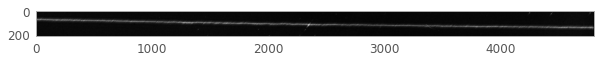

In [12]:
fig = plt.figure(0, figsize=(10,8))
plt.imshow(trail_data, cmap='gray')
plt.grid(None)

# plt.ylim(1983., 2095.)

# print("Cropped image size = %s x %s pixels" %(len(image_crop[0]), len(image_crop)))

Fit setiap x posisi dengan fungsi Gaussian 1D

In [13]:
peak = GaussianModel()
background = ConstantModel()
model = peak + background

approximative_fwhm_px = 5
approximated_intercept = 1000

list_params, positions, fit_data, ims = [], [], [], []

for i in range(0, len(trail_data[0])):
    position = np.arange(0, len(trail_data[::,i]), 1)
    max_intensity = max(trail_data[::,i]) 
    max_position  = np.argmax(trail_data[::,i])
    approximate_stddev = approximative_fwhm_px / (2 * np.sqrt(2 * np.log(2)))

    pars = model.make_params(amplitude=max_intensity, center=max_position, sigma=approximate_stddev, c=approximated_intercept)
    fit_out = model.fit(trail_data[::,i], pars, x=position)

    amp_val, amp_err   = fit_out.params['amplitude'].value, fit_out.params['amplitude'].stderr
    cen_val, cen_err   = fit_out.params['center'].value, fit_out.params['center'].stderr
    sig_val, sig_err   = fit_out.params['sigma'].value, fit_out.params['sigma'].stderr
    fwhm_val, fwhm_err = fit_out.params['fwhm'].value, fit_out.params['fwhm'].stderr

    positions.append(position)
    list_params.append([amp_val, amp_err, cen_val, cen_err, sig_val, sig_err, fwhm_val, fwhm_err])
    fit_data.append(fit_out.best_fit)

In [14]:
N = len(trail_data[0])

fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlim(0, len(positions[0]))
ax.set_ylim(0, 4e4)
ax.set_ylabel('Intensities')    
    
plot1 = plt.plot([], '.')[0] #lines to animate
plot2 = plt.plot([])[0] #lines to animate

# patches = plot1 + plot2 #things to animate

def init():
    #init plot1
    plot1.set_data([], [])
    #init plot2
    plot2.set_data([], [])
    return plot1, plot2 #return everything that must be updated

def animate(i):
    #set label
    label = 'Y axis for X = {}'.format(i+1)
    ax.set_xlabel(label)
    #animate plot1
    plot1.set_data(positions[i], trail_data[::,i])
    #animate plot2
    plot2.set_data(positions[i], fit_data[i])
    return plot1, plot2,ax #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=10, repeat=False)

video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

# anim.save(os.path.join(BASE_DIR, DIRECTORY, 'fwhms_v{}_{}_{}.mp4'.format(PLATENUM, DPI, FILENUM)), fps=60)
plt.close()

In [16]:
# amp_val, amp_err, cen_val, cen_err, sig_val, sig_err, fwhm_val, fwhm_err
list_params = np.array(list_params)

cen_val = list_params[::,2]
cen_err = list_params[::,3]
fwhm_val = list_params[::,6]
fwhm_err = list_params[::,7]

xposition = np.arange(0, len(cen_val), 1)

(0.0, 4800.0)

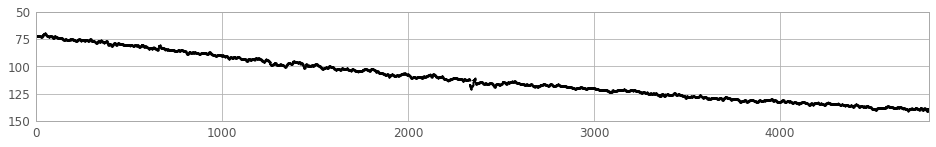

In [50]:
fig = plt.figure(figsize=(16,2))
plt.errorbar(xposition, cen_val, yerr=cen_err, fmt='.', ms=2, color='k')
plt.ylim(150,50)
plt.xlim(0, len(cen_val))

(2500.0, 3500.0)

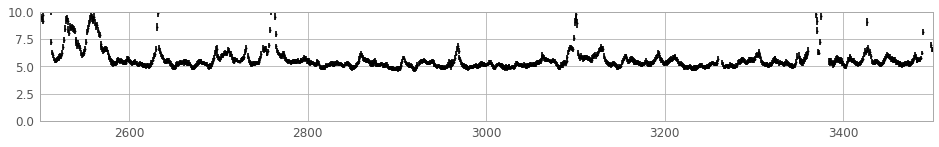

In [18]:
fig = plt.figure(figsize=(16,2))
plt.errorbar(xposition, fwhm_val, yerr=fwhm_err, fmt='.', ms=2, color='k')
plt.ylim(0,10)
plt.xlim(2500, 3500)

Fitting dengan LMFIT (Newville et al, 2020)

Fungsi yang digunakan: polinom orde dua 
$$\begin{eqnarray}
    y_{fit} = c_0 + c_1x + c_2x^2 \\
\end{eqnarray}$$

In [38]:
plt_scale_val = 0.405484 # (arcsec/px), plate scale values from Imaduddin (2019)
plt_scale_err = 0.000064 # (arcsec/px), plate scale values from Imaduddin (2019)

In [53]:
# Fit model with 2nd order polynomial function
polynom_mod = PolynomialModel(2)
poly_params = polynom_mod.guess(cen_val, x=xposition)
poly_result = polynom_mod.fit(cen_val, poly_params, x=xposition, weights=cen_err)

In [54]:
# Save fitting result parameters
fit_val  = poly_result.best_fit
fit_res  = poly_result.residual
fit_err  = poly_result.eval_uncertainty()
fit_rchi = poly_result.redchi

# Save fitting result variables 
c0_val, c0_err, c0_vary = poly_result.params['c0'].value, poly_result.params['c0'].stderr, poly_result.params['c0'].vary
c1_val, c1_err, c1_vary = poly_result.params['c1'].value, poly_result.params['c1'].stderr, poly_result.params['c1'].vary
c2_val, c2_err, c2_vary = poly_result.params['c2'].value, poly_result.params['c2'].stderr, poly_result.params['c2'].vary

# Save fitting result correlations 
c0_c1_correl = poly_result.params["c0"].correl['c1']
c0_c2_correl = poly_result.params["c0"].correl['c2']
c1_c2_correl = poly_result.params["c1"].correl['c2']

Menghitung standar deviasi


In [55]:
res_val, pow_res_val, pow_res_err = [], [], []

for i in range(len(fit_res)):
    pow_res_val.append(fit_res[i]*fit_res[i])
    pow_res_err.append(abs(fit_res[i]*fit_res[i]*np.sqrt(2*fit_err[i]*fit_err[i]/fit_val[i]/fit_val[i])))
    res_val.append(0)

stddev_pixels_val = np.sqrt(sum(pow_res_val)/(len(pow_res_val)-1))
stddev_arcsec_val = plt_scale_val * stddev_pixels_val

# Handling uncertainties
stddev_pixels_err_a = []
for i in range(len(pow_res_err)):
    stddev_pixels_err_a.append(abs(pow_res_err[i]*pow_res_err[i]))
    
stddev_pixels_err = abs(np.sqrt(np.sqrt(sum(stddev_pixels_err_a))/(len(pow_res_err)-1)))
stddev_arcsec_err = abs(stddev_arcsec_val*np.sqrt((plt_scale_err*plt_scale_err/plt_scale_val/plt_scale_val)+(stddev_pixels_err*stddev_pixels_err/stddev_pixels_val/stddev_pixels_val)))

Menghitung diameter seeing (50% FWHM, 95% Gochermann)

In [56]:
seeing50_val = 2.355*stddev_arcsec_val
seeing95_val = 4.895*stddev_arcsec_val

seeing50_err = 2.355*stddev_arcsec_err
seeing95_err = 4.895*stddev_arcsec_err

In [62]:
print("Seeing50 = %.3f +- %.3f arcsec"%(seeing50_val, seeing50_err))
print("Seeing95 = %.3f +- %.3f arcsec"%(seeing95_val, seeing95_err))

Seeing50 = 0.202 +- 0.001 arcsec
Seeing95 = 0.421 +- 0.003 arcsec


Plot hasil perhitungan

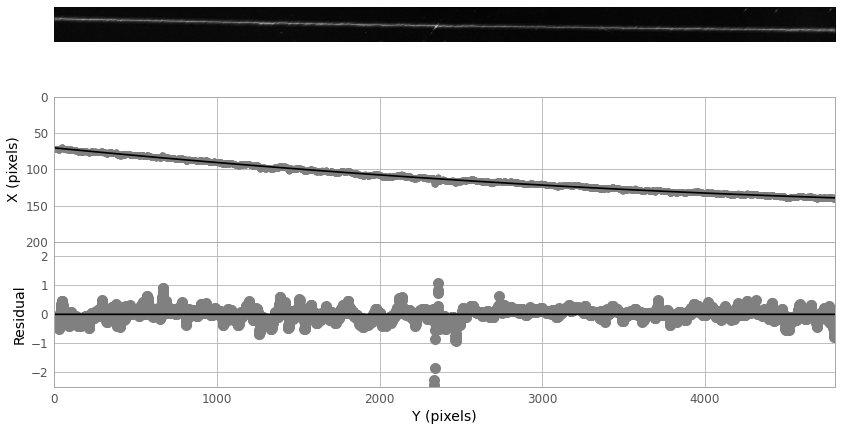

In [65]:
fig, axs = plt.subplots(3, sharex=True, sharey=False, gridspec_kw={'hspace': 0}, figsize=(14., 8.))
# fig.suptitle('Sharing both axes')
axs[0].imshow(trail_data, cmap='gray')
axs[1].plot(xposition, cen_val, '.', markersize=10., color="gray")
axs[1].plot(xposition, fit_val, 'k')
axs[2].plot(xposition, fit_res, 'o', markersize=10., color="gray")
axs[2].plot(xposition, res_val, 'k')

axs[0].grid(None)
axs[0].axis("off")

# axs[0].set_ylim(0, len(image_crop[0]))
axs[1].set_ylim(200, 0)
axs[2].set_ylim(-2.5, 2.5)

# axs[0].set_ylabel('X axis (piksel)')
axs[1].set_ylabel('X (pixels)')
axs[2].set_ylabel('Residual')
axs[2].set_xlabel("Y (pixels)")

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

# py.savefig(filename + '-plot', dpi=300, bbox_inches = 'tight')

Menyimpan parameter ke dalam array dan file

In [69]:
calc_param = {
    'filename': FILENAME,
    'x_pix': len(trail_data[0]),
    'y_pix': len(trail_data),
    'trail_x1': xmin,
    'trail_x2': xmax,
    'trail_y1': ymin,
    'trail_y2': ymax,
    'plt_scale_val': plt_scale_val,
    'plt_scale_err': plt_scale_err,
    'stddev_pix_val': stddev_pixels_val,
    'stddev_pix_err': stddev_pixels_err,
    'stddev_arc_val': stddev_arcsec_val,
    'stddev_arc_err': stddev_arcsec_err,
    'seeing50_val': seeing50_val,
    'seeing50_err': seeing50_err,
    'seeing95_val': seeing95_val,
    'seeing95_err': seeing95_err,
    'red_chisq': fit_rchi,
    'c0_val' : c0_val,
    'c0_err' : c0_err,
    'c0_vary' : c0_vary,
    'c1_val' : c1_val,
    'c1_err' : c1_err,
    'c1_vary' : c1_vary,
    'c2_val' : c2_val,
    'c2_err' : c2_err,
    'c2_vary' : c2_vary,
    'c0_c1_correl': c0_c1_correl,
    'c0_c2_correl': c0_c2_correl,
    'c1_c2_correl': c1_c2_correl
}

result_params = pd.DataFrame(data=calc_param, index=[0])
result_params.to_csv(os.path.join(BASE_DIR, DIRECTORY, 'fwhms_v{}_{}_{}-result.txt'.format(PLATENUM, DPI, FILENUM)), index=False)